# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

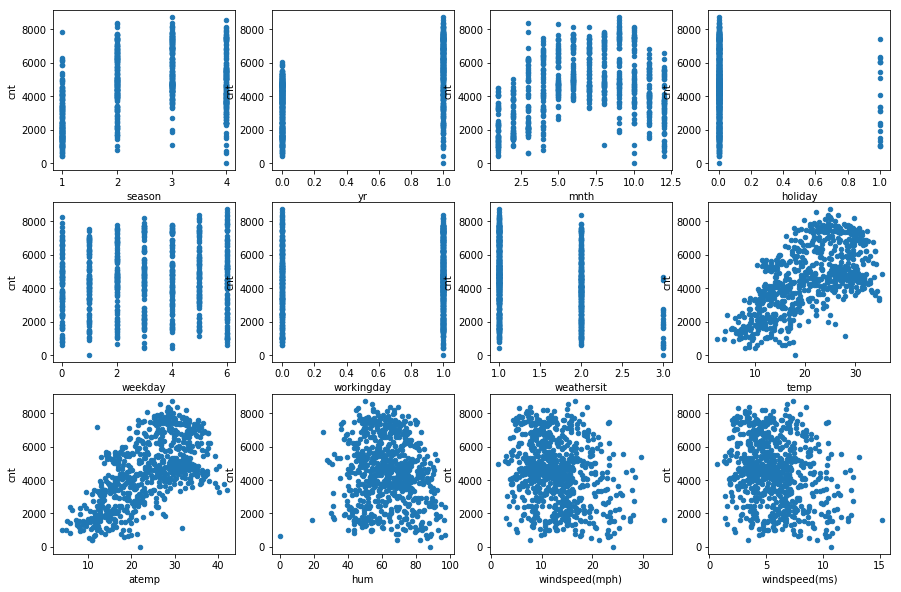

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    x = int(idx / 4)
    y = idx % 4
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[x, y])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: ну что сказать, очевидно, что летом количество в прокат взятых велосипедов будет больше, что собственно мы и видим на графике.  С января по сентябрь количество каждый месяц монотонно возрастает, после до января убывает. Максимальное количество велосипедов в аренде лето +- один месяц.
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: видно линейную зависимость двух признаков temp, atemp, хотя по сути это один и тот же признак, то есть они коррелируют или по другому линейно зависимы.

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [18]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
corr = df.drop('cnt', axis=1).corr()
corr.style.background_gradient(cmap= 'coolwarm')

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
season,1,-0.00184434,0.83144,-0.0105367,-0.00307988,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046
yr,-0.00184434,1,-0.00179243,0.00795431,-0.00546077,-0.00201262,-0.0487265,0.0476036,0.0461061,-0.110651,-0.0118171,-0.0118171
mnth,0.83144,-0.00179243,1,0.0191909,0.00950931,-0.00590095,0.0435281,0.220205,0.227459,0.222204,-0.207502,-0.207502
holiday,-0.0105367,0.00795431,0.0191909,1,-0.10196,-0.253023,-0.0346268,-0.0285555,-0.0325067,-0.0159375,0.00629151,0.00629151
weekday,-0.00307988,-0.00546077,0.00950931,-0.10196,1,0.0357897,0.0310875,-0.000169962,-0.00753713,-0.0522321,0.0142821,0.0142821
workingday,0.012485,-0.00201262,-0.00590095,-0.253023,0.0357897,1,0.0612004,0.0526598,0.0521823,0.024327,-0.0187965,-0.0187965
weathersit,0.019211,-0.0487265,0.0435281,-0.0346268,0.0310875,0.0612004,1,-0.120602,-0.121583,0.591045,0.0395111,0.0395111
temp,0.334315,0.0476036,0.220205,-0.0285555,-0.000169962,0.0526598,-0.120602,1,0.991702,0.126963,-0.157944,-0.157944
atemp,0.342876,0.0461061,0.227459,-0.0325067,-0.00753713,0.0521823,-0.121583,0.991702,1,0.139988,-0.183643,-0.183643
hum,0.205445,-0.110651,0.222204,-0.0159375,-0.0522321,0.024327,0.591045,0.126963,0.139988,1,-0.248489,-0.248489


In [20]:
df.drop('cnt', axis=1).corrwith(df['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [23]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
corr = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
corr.style.background_gradient(cmap= 'coolwarm')


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1,1,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1,1,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [27]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.describe()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,20.310776,23.717699,62.789406,12.762576,5.705220,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,7.505091,8.148059,14.242910,5.192357,2.321125,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,0.670650,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.820424,16.892125,52.000000,9.041650,4.041864,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,20.431653,24.336650,62.666700,12.125325,5.420351,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.872077,30.430100,73.020850,15.625371,6.984967,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,15.198937,8714.000000


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [28]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [29]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [30]:
from sklearn.linear_model import LinearRegression

In [34]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
model = LinearRegression()
model.fit(X, y)

for coef, column in zip(model.coef_, df.columns):
    print(coef, column)


570.8681698112806 season
1021.9637175294769 yr
-141.30232005185658 mnth
-86.76357810238395 holiday
137.2291962130855 weekday
56.38823527436251 workingday
-330.2316126526911 weathersit
367.4749136050979 temp
585.5563613048682 atemp
-145.60790584172227 hum
12458830091266.607 windspeed(mph)
-12458830091465.062 windspeed(ms)


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [35]:
from sklearn.linear_model import Lasso, Ridge

In [36]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса
model_lasso = Lasso(random_state=12345)
model_lasso.fit(X, y)

for coef, column in zip(model_lasso.coef_, df.columns):
    print(coef, column)


560.2416160308869 season
1019.4634940657196 yr
-128.7306270367875 mnth
-86.1527813337111 holiday
137.34789390496312 weekday
55.21237064135672 workingday
-332.3698569623486 weathersit
376.3632362096987 temp
576.530793504551 atemp
-144.12915500348606 hum
-197.1396894024858 windspeed(mph)
-2.8049811945715987e-08 windspeed(ms)


In [43]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса
model_ridge = Ridge(random_state=12345)
model_ridge.fit(X, y)

for coef, column in zip(model_ridge.coef_, df.columns):
    print(coef, column)


563.0645722520173 season
1018.9483787875288 yr
-131.87332028247687 mnth
-86.74609799709266 holiday
138.00511117871898 weekday
55.90311037506441 workingday
-332.3497884990723 weathersit
386.4578891919361 temp
566.3470470600394 atemp
-145.07132729867294 hum
-99.2594410817209 windspeed(mph)
-99.25944115441256 windspeed(ms)


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [156]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500000, 50000)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.

for i, alpha in enumerate(alphas):
    model_lasso = Lasso(alpha, random_state=12345)
    model_ridge = Ridge(alpha, random_state=12345)
    model_ridge.fit(X, y)
    model_lasso.fit(X, y)
    coefs_lasso[i] = model_lasso.coef_
    coefs_ridge[i] = model_ridge.coef_



In [157]:
pd.DataFrame(coefs_lasso, index=map(lambda x: 'alpha=' + str(x), alphas), columns=df.columns[:-1])

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
alpha=1,560.241616,1019.463494,-128.730627,-86.152781,137.347894,55.212371,-332.369857,376.363236,576.530794,-144.129155,-197.139689,-2.804981e-08
alpha=50001,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000e+00
alpha=100001,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000e+00
alpha=150001,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000e+00
alpha=200001,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000e+00
alpha=250001,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000e+00
alpha=300001,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000e+00
alpha=350001,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000e+00
alpha=400001,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000e+00
alpha=450001,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000e+00


In [158]:
pd.DataFrame(coefs_ridge, index=map(lambda x: 'alpha=' + str(x), alphas), columns=df.columns[:-1])

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
alpha=1,563.064572,1018.948379,-131.873320,-86.746098,138.005111,55.903110,-332.349788,386.457889,566.347047,-145.071327,-99.259441,-99.259441
alpha=50001,11.038939,15.773167,7.544151,-1.888344,1.884361,1.676038,-8.203832,17.129674,17.224707,-2.880490,-6.310701,-6.310701
alpha=100001,5.630744,7.952527,3.864962,-0.955523,0.948279,0.851484,-4.154555,8.719402,8.768390,-1.433034,-3.235316,-3.235316
alpha=150001,3.779264,5.316519,2.597896,-0.639587,0.633547,0.570720,-2.781590,5.848146,5.881144,-0.953554,-2.175208,-2.175208
alpha=200001,2.844088,3.992977,1.956481,-0.480662,0.475671,0.429199,-2.090677,4.399439,4.424316,-0.714461,-1.638361,-1.638361
alpha=250001,2.279925,3.197071,1.569077,-0.384998,0.380782,0.343919,-1.674701,3.525981,3.545946,-0.571223,-1.314049,-1.314049
alpha=300001,1.902532,2.665722,1.309734,-0.321092,0.317455,0.286910,-1.396787,2.941902,2.958574,-0.475824,-1.096915,-1.096915
alpha=350001,1.632335,2.285822,1.123961,-0.275382,0.272188,0.246114,-1.197983,2.523829,2.538140,-0.407729,-0.941363,-0.941363
alpha=400001,1.429340,2.000696,0.984342,-0.241064,0.238219,0.215476,-1.048719,2.209796,2.222332,-0.356683,-0.824449,-0.824449
alpha=450001,1.271249,1.778813,0.875577,-0.214352,0.211788,0.191621,-0.932530,1.965263,1.976417,-0.316996,-0.733367,-0.733367


Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

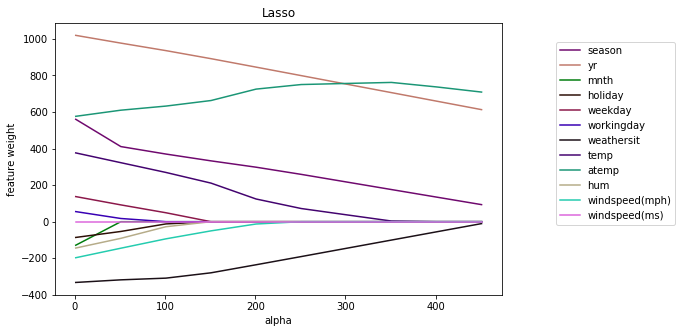

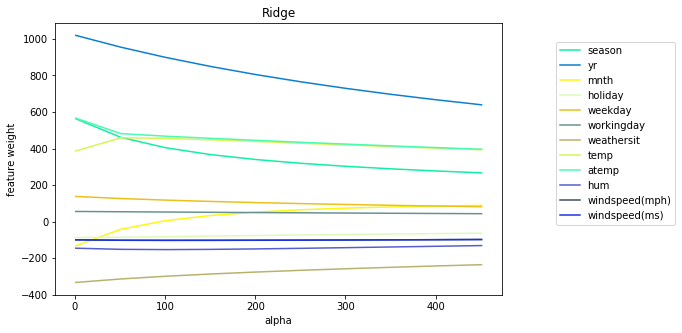

In [65]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: Lasso быстрее уменьшает веса. Это можно увидеть посмотреть на DataFrame выше, значение коэффициентов уменьшаются постепенно, равномерно (Ridge), когда Lasso уменьшает значения рывками. Более математически, разница между предыдущим значением и следующим у Lasso больше. Также можно это увидеть посмотрев на графики прямых, Ridge линии гладкие, почти без резких изменений значений, когда у Lasso наоборот.
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: все веса станут равны 0 при большом alpha, так как функция $\sum_{i=1}^n(y_i - \beta_0 + \beta_1x_1 + ... + \beta_kx_k) + \alpha(w) \rightarrow min$ будет иметь minimum при весах равных нулю, потому что если умножить один из весов не равных нулю на alpha, то будет большое значение, даже не смотря на маленькие веса.
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: ну если взглянуть на таблицу с коэффициентами, можно увидеть что Lasso исключает, Ridge даже при больших значениях alpha не исключает
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: не совсем понял вопрос, вроде как Lasso отбирает как раз таки ИНФОРМАТИВНЫЕ признаки, а Ridge все признаки. То есть не один из признаков не отбирает НЕИНФОРМАТИВНЫЕ, либо ИНФОРМАТИВНЫЕ либо и те и другие.

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [72]:
from sklearn.linear_model import LassoCV

In [152]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 

alphas = np.arange(1, 100, 5)
k = 3

model_lasso_cv = LassoCV(alphas = alphas, random_state=12345, cv = k)
model_lasso_cv.fit(X, y)

result_mse = []

for alpha, array_mse in zip(model_lasso_cv.alphas_, model_lasso_cv.mse_path_):
    result_mse.append((alpha, sum(array_mse) / k))
    
pd.DataFrame(result_mse, columns=['Alpha', 'MSE']).sort_values(by='MSE')


,Alpha,MSE
18,6,790397.728110
17,11,792028.115136
16,16,793826.018330
15,21,795177.429857
14,26,796928.775269
13,31,798642.912659
12,36,800525.557503
11,41,802745.811564
10,46,805329.651078
9,51,808274.166087


In [153]:
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
pd.DataFrame(list(map(lambda x: round(x, 5), model_lasso_cv.coef_)), index=df.columns[:-1], columns=['alpha = {}'.format(model_lasso_cv.alpha_)])


,alpha = 6
season,532.01898
yr,1015.06022
mnth,-100.03953
holiday,-83.29396
weekday,132.50447
workingday,51.55709
weathersit,-330.55986
temp,370.67986
atemp,581.39693
hum,-140.00741


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [154]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
array_mse = np.transpose(model_lasso_cv.mse_path_)


for i in range(len(array_mse)):
    mX = array_mse[i][0]
    for j in range(len(array_mse[i])):
        if mX > array_mse[i][j]:
            mX = array_mse[i][j]
            index_alpha = model_lasso_cv.alphas_[j]
                   
    print(mX, index_alpha)




843336.1814988202 41
772598.49562777 6
745668.6059608093 1


Text(0.5, 1.0, 'Lasso')

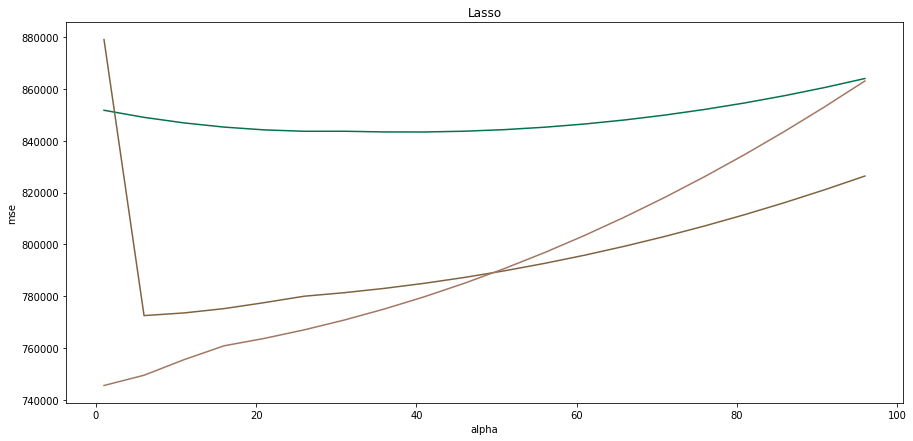

In [155]:
plt.figure(figsize=(15, 7))
for mse in array_mse:
    plt.plot(model_lasso_cv.alphas_, mse, color=np.random.rand(3))
plt.xlabel("alpha")
plt.ylabel("mse")
plt.title("Lasso")

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: сезон, год, температура, день недели. Все очевидные и не нуждаются в интерпритации, кроме года. Видимо в прошлом году только запустили прокат и спрос был не такой большой, так как еще мало людей знало о такой услуге. На графиках видны корреляции между этими признаками. 
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: ветер, влажность и оценка погоды. Чем меньше оценка(лучше погода), тем больше заказов, чем меньше скорость ветра, тем больше заказов и аналогично с влажностью.
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: windspeed(ms) только один признак близок к нулю, вообще говоря он влияет, но он коллинеарен с другим признаком, скорее всего поэтому его модель исключила, имею ввиду высислила коэффициент при этом признаке равным нулю, то есть он не значимый для нашей модели.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.